# 트위터 API로 연관 키워드 분석하기

### 바로가기

- [<Step1. API 호출> : 트위터 API로 데이터 가져오기](#<Step1.-API-호출>-:-트위터-API로-데이터-가져오기)
    - [API 데이터로 데이터 프레임 생성하기]
- [<Step2. 추출> : 키워드 추출](#<Step2.-추출>-:-키워드-추출)
    - [텍스트 데이터 전처리]
    - [nltk, konlpy를 이용한 키워드 추출]
- [<Step3. 분석> : 연관 분석을 이용한 키워드 분석](#<Step3.-분석>-:-연관-분석을-이용한-키워드-분석)
    - [연관 키워드 추출하기]
    - [단어 빈도 추출하기]
- [<Step4. 시각화> : 연관 키워드 네트워크 시각화](#<Step4.-시각화>-:-연관-키워드-네트워크-시각화)
    - [연관 키워드 네트워크 시각화]

-----

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. API 호출> : 트위터 API로 데이터 가져오기

-----

##### 트위터 API 가져오기

In [5]:
import tweepy

api_key = "RvnZeIl8ra88reu8fm23m0bST"
api_secret = "wTRylK94GK2KmhZUnqXonDaIszwAsS6VPvpSsIo6EX5GQLtzQo"
access_token = "959614462004117506-dkWyZaO8Bz3ZXh73rspWfc1sQz0EnDU"
access_token_secret = "rxDWfg7uz1yXMTDwijz0x90yWhDAnmOM15R6IgC8kmtTe"

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

# twitter API를 사용하기 위한 준비입니다.
api = tweepy.API(auth)

In [6]:
# 크롤링된 데이터를 저장할 데이터 프레임입니다.
columns = ['created', 'tweet_text']
df = pd.DataFrame(columns=columns)

keyword='코로나'

# twitter API를 사용하여 ‘손흥민’이 포함된 100페이지의 트윗들을 크롤링한 뒤, ‘text’, ‘created_at’ 정보를 데이터 프레임으로 저장합니다.
for i in range(1,100):
    print("Get data", str(i/500*100), "% complete..")
    tweets = api.search(keyword)
    for tweet in tweets:
        tweet_text = tweet.text
        created = tweet.created_at
        row = [created, tweet_text]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
print("Get data 100 % complete..")

Get data 0.2 % complete..
Get data 0.4 % complete..
Get data 0.6 % complete..
Get data 0.8 % complete..
Get data 1.0 % complete..
Get data 1.2 % complete..
Get data 1.4000000000000001 % complete..
Get data 1.6 % complete..
Get data 1.7999999999999998 % complete..
Get data 2.0 % complete..
Get data 2.1999999999999997 % complete..
Get data 2.4 % complete..
Get data 2.6 % complete..
Get data 2.8000000000000003 % complete..
Get data 3.0 % complete..
Get data 3.2 % complete..
Get data 3.4000000000000004 % complete..
Get data 3.5999999999999996 % complete..
Get data 3.8 % complete..
Get data 4.0 % complete..
Get data 4.2 % complete..
Get data 4.3999999999999995 % complete..
Get data 4.6 % complete..
Get data 4.8 % complete..
Get data 5.0 % complete..
Get data 5.2 % complete..
Get data 5.4 % complete..
Get data 5.6000000000000005 % complete..
Get data 5.800000000000001 % complete..
Get data 6.0 % complete..
Get data 6.2 % complete..
Get data 6.4 % complete..
Get data 6.6000000000000005 % comp

RateLimitError: [{'message': 'Rate limit exceeded', 'code': 88}]

In [7]:
df.to_csv("tweet_temp.csv", index=False)

# <Step2. 추출> : 키워드 추출

### [텍스트 데이터 전처리]

In [4]:
df = pd.read_csv("tweet_temp.csv")
df.head()

,created,tweet_text
0,2020-10-29 09:07:12,RT @JUN34_: 코로나 일상 그대로 담았고 타팬인 친구들도 노래 진짜 공감된다...
1,2020-10-29 09:07:07,RT @gotry7: 만화 20세기소년에서 세균병기에 사망한 사람이 15만명이었고 ...
2,2020-10-29 09:07:07,@fable_of_ 바빴던 거 알아서 다행이다... 어떻게 살아왔던 거야 쟈기ㅠㅠ ...
3,2020-10-29 09:07:04,RT @little_bibu: RT♡ 알티해주신 분들 중 \n세분을 뽑아 포근한 빵...
4,2020-10-29 09:06:57,"[코로나19] 일본, 누적 확진자 10만명 돌파…도쿄 신규 확진 221명\n\nht..."


In [8]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거합니다.
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규표현식을 나타냅니다.
    result = hangul.sub('', text)
    return result

In [9]:
# ‘tweet_text’ 피처에 이를 적용합니다.
df['ko_text'] = df['tweet_text'].apply(lambda x: text_cleaning(x))
df.head()

,created,tweet_text,ko_text
0,2020-10-30 00:10:26,"코로나19로 바뀐 일상…""건강관리도 비대면으로"" 홈트레닝 활성화·마라톤 대회까지 비...",코로나로 바뀐 일상건강관리도 비대면으로 홈트레닝 활성화마라톤 대회까지 비대면으로 진...
1,2020-10-30 00:10:26,RT @charisclinic: 리) 코로나 한국이 제일 심한 나라중 하나였을때 내...,리 코로나 한국이 제일 심한 나라중 하나였을때 내가 했던 예언 아닌 예언 생각난...
2,2020-10-30 00:10:20,RT @treasuremembers: 안녕하세요 트메~! 예담이에요\n요즘 코로나 ...,안녕하세요 트메 예담이에요요즘 코로나 때문에 평소같지 않고 무기력하고 답답하겠...
3,2020-10-30 00:10:19,"삼성전자도 코로나속 사상 최대 매출. 3분기 매출 67조, 영업익 12.3조 전년 ...",삼성전자도 코로나속 사상 최대 매출 분기 매출 조 영업익 조 전년 동기 각각 증...
4,2020-10-30 00:10:18,RT @Terminator261: 조국장관 덕분에 고위 공직자들의 추잡스런 행태가 ...,조국장관 덕분에 고위 공직자들의 추잡스런 행태가 다 드러나고 코로나 덕분에 선진...


### [konlpy를 이용한 키워드 추출]

In [10]:
from konlpy.tag import Okt
from collections import Counter

# 한국어 약식 불용어사전 예시 파일입니다. 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "data/korean_stopwords.txt"
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]

def get_nouns(x):
    nouns_tagger = Okt()
    nouns = nouns_tagger.nouns(x)
    
    # 한글자 키워드를 제거합니다.
    nouns = [noun for noun in nouns if len(noun) > 1]
    
    # 불용어를 제거합니다.
    nouns = [noun for noun in nouns if noun not in stopwords]
    
    return nouns

In [11]:
# ‘ko_text’ 피처에 이를 적용합니다.
df['nouns'] = df['ko_text'].apply(lambda x: get_nouns(x))
print(df.shape)
df.head()

(1440, 4)


,created,tweet_text,ko_text,nouns
0,2020-10-30 00:10:26,"코로나19로 바뀐 일상…""건강관리도 비대면으로"" 홈트레닝 활성화·마라톤 대회까지 비...",코로나로 바뀐 일상건강관리도 비대면으로 홈트레닝 활성화마라톤 대회까지 비대면으로 진...,"[코로나, 일상, 건강, 관리, 대면, 홈트레닝, 활성화, 마라톤, 대회, 대면, ..."
1,2020-10-30 00:10:26,RT @charisclinic: 리) 코로나 한국이 제일 심한 나라중 하나였을때 내...,리 코로나 한국이 제일 심한 나라중 하나였을때 내가 했던 예언 아닌 예언 생각난...,"[코로나, 한국, 제일, 나라, 예언, 예언, 한국, 수혜, 라거, 오늘, 국내, ..."
2,2020-10-30 00:10:20,RT @treasuremembers: 안녕하세요 트메~! 예담이에요\n요즘 코로나 ...,안녕하세요 트메 예담이에요요즘 코로나 때문에 평소같지 않고 무기력하고 답답하겠...,"[트메, 예담, 요즘, 코로나, 때문, 평소, 무기, 컨텐츠, 노래, 트위터, 소통..."
3,2020-10-30 00:10:19,"삼성전자도 코로나속 사상 최대 매출. 3분기 매출 67조, 영업익 12.3조 전년 ...",삼성전자도 코로나속 사상 최대 매출 분기 매출 조 영업익 조 전년 동기 각각 증...,"[코로나, 사상, 최대, 매출, 분기, 매출, 영업, 동기, 증가, 미국, 테크, ..."
4,2020-10-30 00:10:18,RT @Terminator261: 조국장관 덕분에 고위 공직자들의 추잡스런 행태가 ...,조국장관 덕분에 고위 공직자들의 추잡스런 행태가 다 드러나고 코로나 덕분에 선진...,"[조국, 장관, 덕분, 고위, 공직자, 추잡, 행태, 코로나, 덕분, 선진국, 밑바..."


# <Step3. 분석> : 연관 분석을 이용한 키워드 분석

### [연관 키워드 추출하기]

##### **연관 분석 연습**

In [12]:
from apyori import apriori

# 장바구니 형태의 데이터(트랜잭션 데이터)를 생성
transactions = [
    ['손흥민', '시소코'],
    ['손흥민', '케인'],
    ['손흥민', '케인', '포체티노']
]

# 연관 분석을 수행
results = list(apriori(transactions))
for result in results:
    print(result)

RelationRecord(items=frozenset({'손흥민'}), support=1.0, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민'}), confidence=1.0, lift=1.0)])
RelationRecord(items=frozenset({'시소코'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'시소코'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'케인'}), support=0.6666666666666666, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'케인'}), confidence=0.6666666666666666, lift=1.0)])
RelationRecord(items=frozenset({'포체티노'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'포체티노'}), confidence=0.3333333333333333, lift=1.0)])
RelationRecord(items=frozenset({'손흥민', '시소코'}), support=0.3333333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'손흥민', '시소코'}), confidence=0.3333333333333333, lift=1.0), Or

In [13]:
# 데이터 프레임 형태로 정리합니다.
columns = ['source', 'target', 'support']
network_df = pd.DataFrame(columns=columns)

# 규칙의 조건절을 source, 결과절을 target, 지지도를 support 라는 데이터 프레임의 피처로 변환합니다.
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        row = [items[0], items[1], result.support]
        series = pd.Series(row, index=network_df.columns)
        network_df = network_df.append(series, ignore_index=True)

network_df.head()

,source,target,support
0,손흥민,시소코,0.333333
1,손흥민,케인,0.666667
2,손흥민,포체티노,0.333333
3,케인,포체티노,0.333333


##### **트위터 연관 키워드 분석**

In [14]:
# 트랜잭션 데이터를 추출합니다.
transactions = df['nouns'].tolist()
#transactions = [transaction for transaction in transactions if transaction] # 공백 문자열을 방지합니다.
print(transactions[:10])

[['코로나', '일상', '건강', '관리', '대면', '홈트레닝', '활성화', '마라톤', '대회', '대면', '진행', '시장', '원대', '급성', '뉴틴', '주목', '김수현'], ['코로나', '한국', '제일', '나라', '예언', '예언', '한국', '수혜', '라거', '오늘', '국내', '주식시장', '미국', '유럽', '커플링', '패턴', '일부'], ['트메', '예담', '요즘', '코로나', '때문', '평소', '무기', '컨텐츠', '노래', '트위터', '소통', '더욱', '트레'], ['코로나', '사상', '최대', '매출', '분기', '매출', '영업', '동기', '증가', '미국', '테크', '기업', '호실', '느낌'], ['조국', '장관', '덕분', '고위', '공직자', '추잡', '행태', '코로나', '덕분', '선진국', '밑바닥', '요즘', '실컷', '보고', '조국', '장관', '끼리', '주접'], ['비말', '차단', '마스크', '유한킴벌리', '국산', '덴탈', '마스크', '미세먼지', '마스크', '코로나', '확산', '코로나', '진자', '방문', '사회', '거리', '두기'], ['백악관', '코로나', '대유행', '통제', '발표', '한국', '방역', '구멍', '마스크', '제대로', '국민', '건강', '위협', '미군', '방역'], ['학교', '기준', '알리', '학교', '모범', '학교', '뉴저지', '코로나', '사건', '뉴욕', '학교', '학교', '상도', '덕분'], ['본인', '지지자', '코로나', '퇴치', '생각', '진자', '수가', '최고'], ['미국', '입국', '미군', '관련', '코로나', '확진']]


In [15]:
# 연관 분석을 수행합니다.
results = list(apriori(transactions,
                        min_support=0.1))
print(results) 

[RelationRecord(items=frozenset({'국내'}), support=0.13402777777777777, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'국내'}), confidence=0.13402777777777777, lift=1.0)]), RelationRecord(items=frozenset({'마스크'}), support=0.11458333333333333, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'마스크'}), confidence=0.11458333333333333, lift=1.0)]), RelationRecord(items=frozenset({'미국'}), support=0.14305555555555555, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'미국'}), confidence=0.14305555555555555, lift=1.0)]), RelationRecord(items=frozenset({'방역'}), support=0.10347222222222222, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'방역'}), confidence=0.10347222222222222, lift=1.0)]), RelationRecord(items=frozenset({'산업'}), support=0.1, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'산업'}), confidence=0.1, lift=1.0)]), RelationR

In [16]:
# 데이터 프레임 형태로 정리합니다.
columns = ['source', 'target', 'support']
network_df = pd.DataFrame(columns=columns)

# 규칙의 조건절을 source, 결과절을 target, 지지도를 support 라는 데이터 프레임의 피처로 변환합니다.
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        row = [items[0], items[1], result.support]
        series = pd.Series(row, index=network_df.columns)
        network_df = network_df.append(series, ignore_index=True)

network_df.head()

,source,target,support
0,국내,코로나,0.134028
1,코로나,마스크,0.114583
2,미국,코로나,0.143056
3,코로나,방역,0.103472
4,코로나,산업,0.100000


##### 말뭉치 추출

In [ ]:
# 말뭉치를 추출합니다.
tweet_corpus = "".join(df['ko_text'].tolist())
print(tweet_corpus)

In [18]:
from konlpy.tag import Okt
from collections import Counter

# 명사 키워드를 추출합니다.
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(tweet_corpus)
count = Counter(nouns)

# 한글자 키워드를 제거합니다.
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'코로나': 1618, '증가': 461, '방역': 298, '마스크': 294, '진자': 289, '확산': 282, '모두': 238, '국내': 220, '미국': 206, '덕분': 200, '치료': 192, '한국': 190, '감염': 177, '매출': 176, '조국': 176, '장관': 176, '시설': 169, '판매': 148, '산업': 144, '점검': 142, '위험': 142, '오늘': 134, '극복': 124, '작용': 122, '요즘': 121, '대면': 120, '아마존': 110, '실적': 110, '이재명': 110, '피임': 108, '수혜': 107, '유럽': 106, '경기도': 106, '행사': 106, '여파': 106, '생산': 106, '소비': 106, '투자': 106, '활동': 106, '주요': 106, '지표': 106, '동시': 106, '개월': 106, '자동차': 106, '반도체': 106, '중심': 106, '수출': 106, '회복': 106, '추석': 106, '명절': 106, '소매': 106, '긍정': 106, '분석': 106, '최대': 105, '예언': 104, '선진국': 104, '시대': 99, '클럽': 98, '제일': 96, '차단': 96, '사회': 96, '거리': 96, '두기': 96, '분기': 88, '기업': 88, '고위': 88, '공직자': 88, '추잡': 88, '행태': 88, '밑바닥': 88, '실컷': 88, '보고': 88, '끼리': 88, '주접': 88, '비말': 88, '국산': 88, '덴탈': 88, '방문': 88, '혈장': 85, '세계': 85, '결과': 82, '사후': 81, '학교': 80, '이상': 80, '하나': 79, '자제': 79, '환자': 78, '건강': 76, '보스턴': 76, '개봉': 76, '우리': 75, '자살': 72, '복도

##### 단어 빈도 점수 추가

In [19]:
# 키워드와 키워드 빈도 점수를 ‘node’, ‘nodesize’ 라는 데이터 프레임의 피처로 생성합니다.
node_df = pd.DataFrame(remove_char_counter.items(), columns=['node', 'nodesize'])
node_df = node_df[node_df['nodesize'] >= 50] # 시각화의 편의를 위해 ‘nodesize’ 50 이하는 제거합니다.
node_df.head()

,node,nodesize
0,코로나,1618
1,일상,60
2,건강,76
3,관리,60
4,대면,120


# <Step4. 시각화> : 연관 키워드 네트워크 시각화

### [연관 키워드 네트워크 시각화]

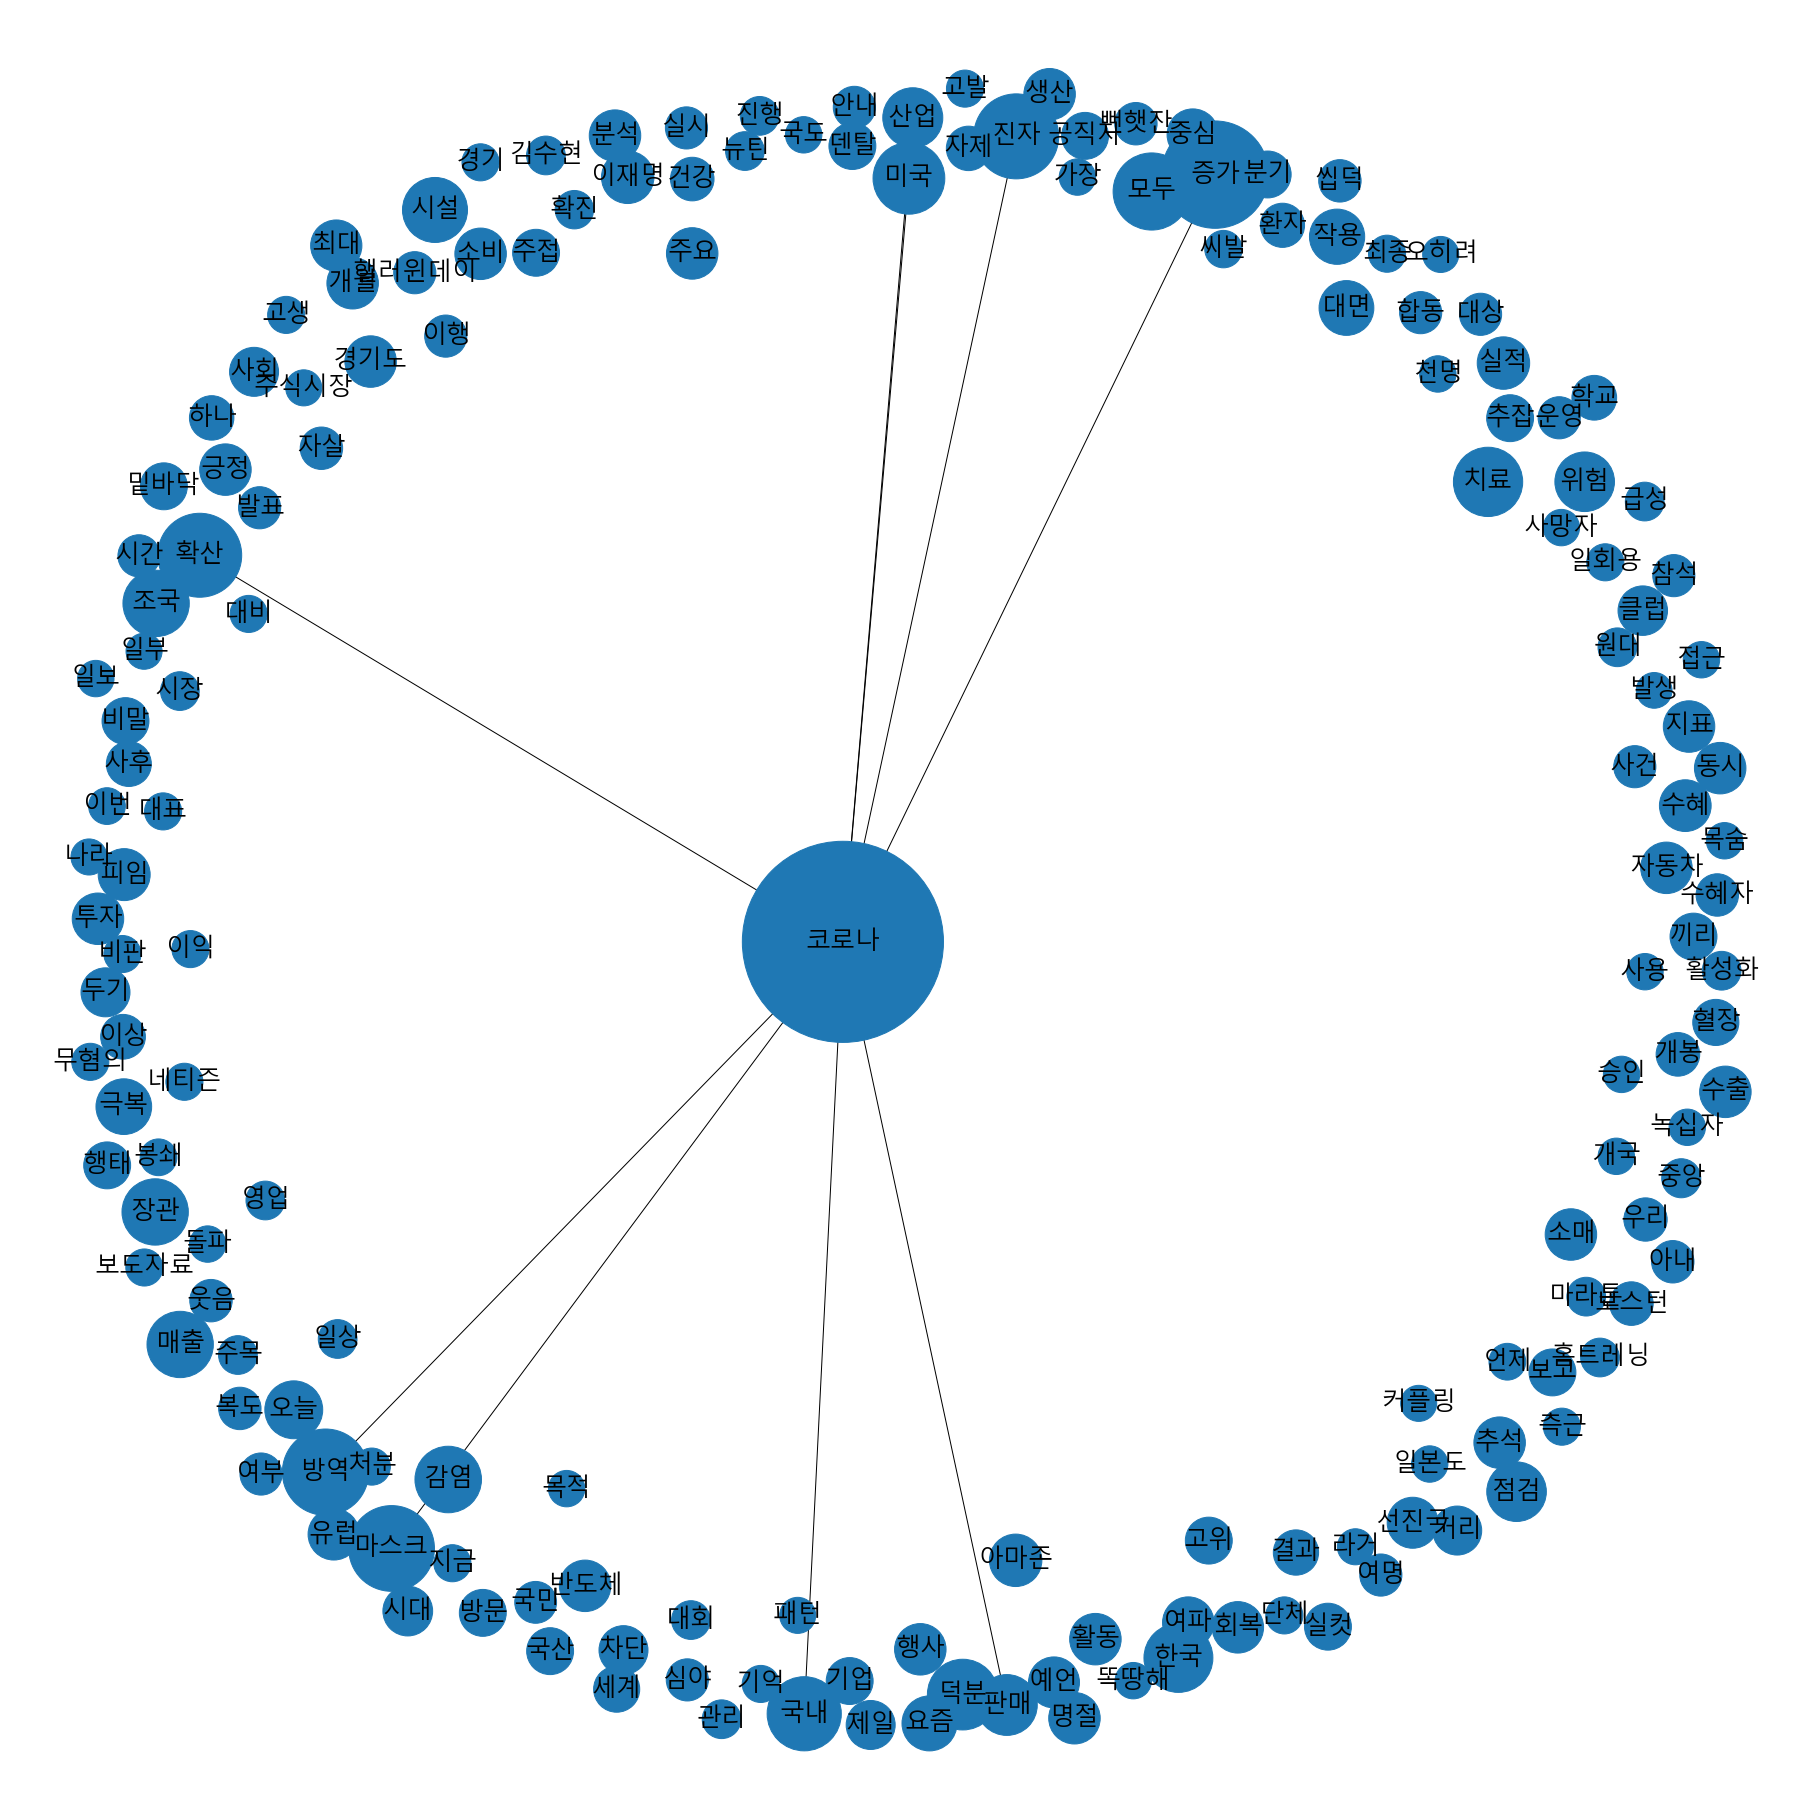

In [20]:
#pip install networkx
import networkx as nx
plt.figure(figsize=(25,25))

# networkx 그래프 객체를 생성합니다.
G = nx.Graph()

# node_df의 키워드 빈도수를 데이터로 하여, 네트워크 그래프의 ‘노드’ 역할을 하는 원을 생성합니다.
for index, row in node_df.iterrows():
    G.add_node(row['node'], nodesize=row['nodesize'])
    
# network_df의 연관 분석 데이터를 기반으로, 네트워크 그래프의 ‘관계’ 역할을 하는 선을 생성합니다.
for index, row in network_df.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])
    
# 그래프 디자인과 관련된 파라미터를 설정합니다.
pos = nx.spring_layout(G, k=0.6, iterations=50)
sizes = [G.nodes[node]['nodesize']*25 for node in G]
nx.draw(G, pos=pos, node_size=sizes)

# Windows 사용자는 AppleGothic 대신,'Malgun Gothic'. 그 외 OS는 OS에서 한글을 지원하는 기본 폰트를 입력합니다.
nx.draw_networkx_labels(G, pos=pos, font_family='Malgun Gothic', font_size=25)

# 그래프를 출력합니다.
ax = plt.gca()
plt.show()